In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/research/prompt_engineering/RL
!pip install tiktoken
!pip install --upgrade "httpx<0.28"
import json
import rl
from openai import OpenAI
with open("config.json") as config_file:
    config = json.load(config_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/research/prompt_engineering/RL


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


The OpenAI API does not have a direct parameter to set a random seed for reproducibility in its responses. The behavior of the models is inherently non-deterministic due to randomness in the generation process.

In [ ]:
VOCAL = 50000
EPOCHS = 10
PROMPT_LENGTH = 7
PROMPT_INIT = "Find material entities."
LR = 0.001
HIDDEN = 64
EXP_ID = 5
PRINT_INTERVAL = 1
SAVE = False

PROMPTS, PREDICTIONS, SCORES, REWARDS = rl.do_training(
    prompt_init=PROMPT_INIT, epochs=EPOCHS, learning_rate=LR,
    vocal_size=VOCAL, prompt_length=PROMPT_LENGTH, hidden=HIDDEN,
    exp_id=EXP_ID, print_interval=PRINT_INTERVAL, save_results=SAVE,
    client=OpenAI(api_key=config["OPENAI_API_KEY"])
    )

Initial prompt: Find material entities.
Predictions: [['vanadium dioxide', ' graphene', ' dielectric film', ' gold mirror'], ['phononic crystals', ' acoustic metamaterials', ' piezoelectric materials', ' defect mode metamaterial', ' Gradient Index (GRIN) system', ' topological metamaterial'], ['Douglas fir wood', ' metamaterial catalysts', ' microlattices', ' bimodal pores', ' 316L stainless steel', ' Fe', ' Co']]
Scores: [0.7272727272727273, 0.7272727272727272, 0.6666666666666666]
Reward: 0.7070707070707071

0 Find material entities.  entrada 
Reward: 0.81990231990232
1 Find material entities.  • 
Reward: 0.7863247863247863
2 Find material entities. ex 
Reward: 0.7863247863247863
3 Find material entities. � 
Reward: 0.7863247863247863
4 Find material entities.  Nä 
Reward: 0.735042735042735
5 Find material entities. ил 
Reward: 0.7897435897435897
6 Find material entities. tooltip 
Reward: 0.8008547008547008
7 Find material entities. Auf 
Reward: 0.81990231990232
8 Find material entiti

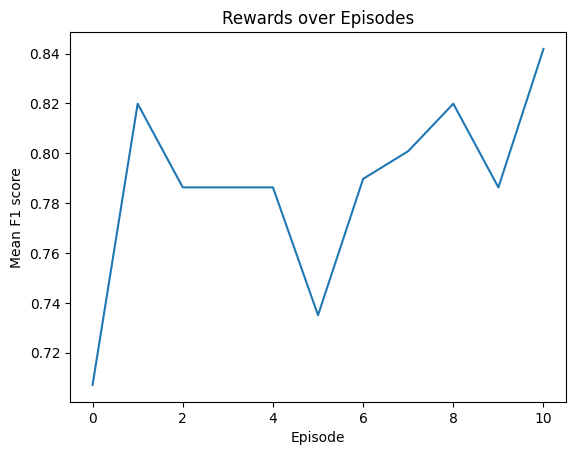

In [ ]:
import matplotlib.pyplot as plt

plt.plot(REWARDS)
plt.xlabel("Episode")
plt.ylabel("Mean F1 score")
plt.title("Rewards over Episodes")
plt.show()

In [ ]:
# prompt: extract filenames with a certain prefix

import os
import glob

def extract_filenames_with_prefix(directory, prefix):
    """
    Extracts filenames with a specific prefix from a directory.

    Args:
        directory: The directory to search in.
        prefix: The prefix to match.

    Returns:
        A list of filenames with the given prefix.
    """

    matching_files = glob.glob(os.path.join(directory, prefix + '*'))
    filenames = [os.path.basename(file) for file in matching_files]
    return filenames

# Example usage (replace with your directory and prefix)
# directory_path = "/content/drive/MyDrive/research/prompt_engineering/RL"
# file_prefix = "results"
# matching_files = extract_filenames_with_prefix(directory_path, file_prefix)
# print(matching_files)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
import glob

def extract_filenames_with_prefix(directory, prefix):
    matching_files = glob.glob(os.path.join(directory, prefix + '*'))
    filenames = [os.path.basename(file) for file in matching_files]
    return filenames

def load_results(exp: str):
    exp_names = extract_filenames_with_prefix("results", exp)
    all_results = []
    # Load results in dataframes
    for exp_name in exp_names:
        result = pd.read_csv(f"results/{exp_name}")["Reward"]
        all_results.append(result)
    return all_results

In [ ]:
all_results = load_results("Find material entities._e_10_l_0.001_v_50000_len_7_h_64_s_1234_")

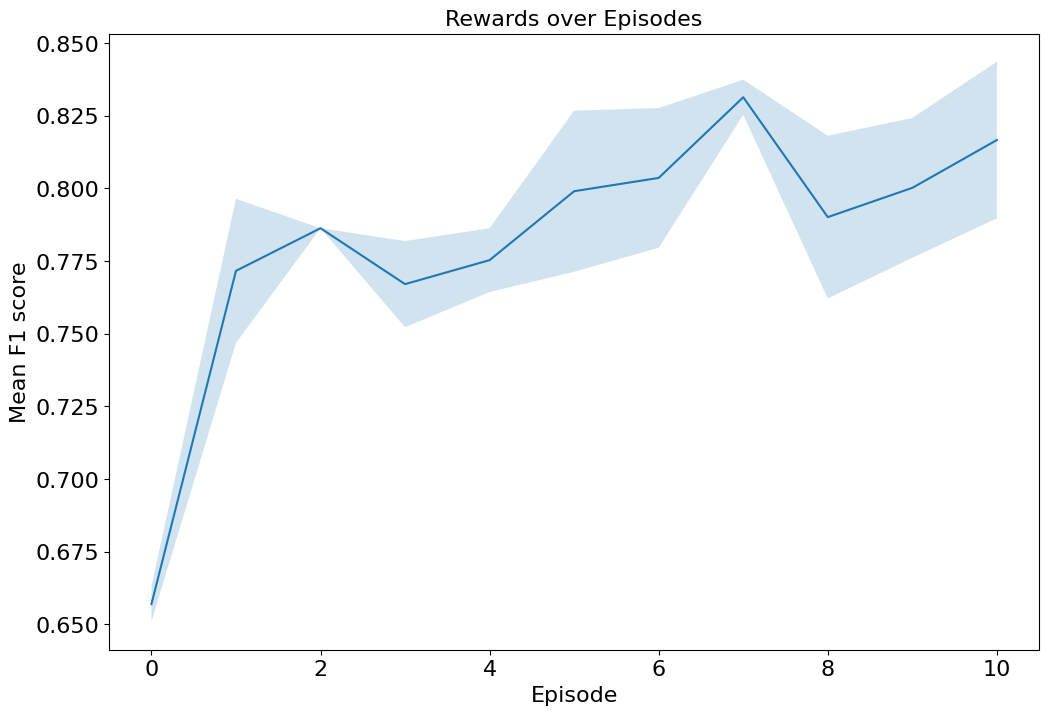

In [ ]:
# prompt: I have a list of test results. Calculate the mean and standard deviation across these results. Plot results with shaded area. Make fontsize and figure size arguments

import matplotlib.pyplot as plt
import numpy as np

def plot_results(all_results, fontsize=12, figsize=(10, 6)):
    """Plots the mean and standard deviation of test results."""

    # Calculate mean and standard deviation
    mean_results = np.mean(all_results, axis=0)
    std_results = np.std(all_results, axis=0)

    # Plotting
    plt.figure(figsize=figsize)
    x = np.arange(len(mean_results))
    plt.plot(x, mean_results)
    plt.fill_between(x, mean_results - std_results, mean_results + std_results, alpha=0.2)

    plt.xlabel("Episode", fontsize=fontsize)
    plt.ylabel("Mean F1 score", fontsize=fontsize)
    plt.title("Rewards over Episodes", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.show()

# Example with custom fontsize and figure size
plot_results(all_results, fontsize=16, figsize=(12, 8))